In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.lm_partial import analytic_lm_params, X_end_formula
from aeons.covariance import X_mu, X_Sigmainv, logX_mu
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

In [2]:
format = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 9pt font in plots, to match 9pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    'axes.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'patch.linewidth': 0.5,
    'legend.fancybox': False,
    'legend.shadow': False
}
plt.rcParams.update(format)

In [3]:
def minimise_bandwidth(logL, X_mean, ndead, alphas):
    theta_best = None
    logZi = -np.inf
    for alpha in alphas:
        startf = int(ndead * (1 - alpha))
        Nex = startf
        penalty = Nex * np.log(Nex) - Nex if Nex != 0 else 0
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        ls = LS(logL, full, X_mean)
        theta = analytic_lm_params(logLf, X_meanf, 10)
        logZf = ls.logZ(theta)
        if logZf > logZi:
            theta_best = theta
    return theta_best

In [4]:
def gaussian_L(X, theta):
    d, sigma = theta
    return np.exp(-X**(2/d)/(2*sigma**2))

#### **L(X)X plot**

In [134]:
nk = nk_dead_live(nlive=100, ndead=4000)
logX_mean = logX_mu(nk)

In [135]:
logXarray = np.linspace(-70, 0, 1000)
Xarray = np.exp(logXarray)
theta = [10, 0.01]
logL = middle.func(Xarray, theta)
L = np.exp(logL)

In [136]:
Ztrue = np.trapz(L, Xarray)
LlogL = np.nan_to_num(L/Ztrue * np.log(L/Ztrue))
H = np.trapz(LlogL, Xarray)
H

/tmp/ipykernel_9860/342145044.py:2: RuntimeWarning: divide by zero encountered in log
  LlogL = np.nan_to_num(L/Ztrue * np.log(L/Ztrue))
/tmp/ipykernel_9860/342145044.py:2: RuntimeWarning: invalid value encountered in multiply
  LlogL = np.nan_to_num(L/Ztrue * np.log(L/Ztrue))


32.79765604572788

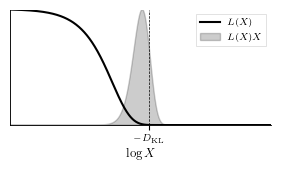

In [137]:
fig, ax1 = plt.subplots(figsize=(3.37, 1.5))
ax2 = ax1.twinx()
ax1.plot(logXarray, L, color='black', label=r"$L(X)$")
ax2.fill(logXarray, L*Xarray, lw=1, color='black', alpha=0.2, label=r"$L(X)X$")
ax2.axvline(-H, ls='--', lw=0.5, color='black')
for ax in ax1, ax2:
    ax.set_yticks([])
    ax.set_xticks([-H], [f'$-D_\mathrm{{KL}}$'])
    ax.margins(x=0, y=0)
ax1.set_xlabel(r'$\log X$');
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.savefig('../../../report/figures/LX.pdf', format='pdf', bbox_inches='tight')

#### **Plots of mean vs true X for Gaussian likelihood**

In [229]:
ndead = 5000
nlive = 500
nk = nk_dead_live(nlive=500, ndead=5000)
logX_mean = logX_mu(nk)
X_mean = X_mu(nk)

In [239]:
theta = [0, 4, 0.01]
logXarray = np.linspace(-30, 0, 1000)
Xarray = np.exp(logXarray)
logLarray = full.func(Xarray, theta)
Larray = np.exp(logLarray)

X = generate_Xs(nk)
logX = np.log(X)
logL = full.func(X, theta)
L = np.exp(logL)

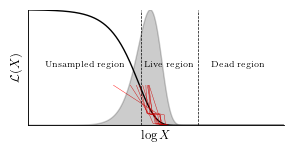

In [241]:
fig, ax = plt.subplots(figsize=(3.3, 1.5))
ax1 = plt.twinx(ax)
ax.plot(logXarray, Larray, lw=1, color='black')
for _ in range(10):
    X = generate_Xs(nk)
    ax.plot(np.log(X), L, color='red', lw=.3)
ax1.fill(logXarray, Larray*Xarray, lw=1, color='black', alpha=.2)
ax.axvline(logX_mean[-1], ls='--', lw=.5, color='black')
ax.axvline(logX_mean[ndead], ls='--', lw=.5, color='black')
ax.margins(0)
ax1.margins(0)
ax.set_yticks([])
ax1.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('$\log X$')
ax.set_ylabel('$\mathcal{{L}}(X)$')
ax.text(-28, 0.5, 'Unsampled region', fontsize=6)
ax.text(-16.4, 0.5, 'Live region', fontsize=6)
ax.text(-8.5, 0.5, 'Dead region', fontsize=6)
plt.savefig('../../../report/figures/regions.pdf', format='pdf', bbox_inches='tight')

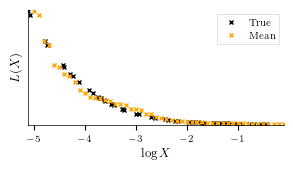

In [8]:

plt.plot(logX, L, 'x', ms=3, label='True', color='black')
plt.plot(logX_mean, L, 'x', ms=3, label='Mean', color='orange')
plt.yticks([])
plt.ylabel(r'$L(X)$')
plt.xlabel(r'$\log X$')
plt.margins(x=0, y=0.01)
plt.legend();
plt.savefig('mean_vs_true.pdf', format='pdf', bbox_inches='tight')

#### **Plot of live points at end of run**

In [1]:
nk = nk_dead_live(500, 1000)
plt.figure(figsize=(6.7, 2))
plt.plot(nk)
plt.ylim(0, 550)
plt.xlim(0, 1600)
plt.xticks([])
plt.xlabel("Iterations")
plt.yticks([])
plt.ylabel("$n_\mathrm{live}$")
plt.margins(x=0, y=0.01)
plt.savefig('../../../report/figures/nk_dead_live.pdf', format='pdf', bbox_inches='tight')

NameError: name 'nk_dead_live' is not defined

#### **Variation in live points**

In [157]:
ndead = 1600
nk = nk_dead_live(nlive=100, ndead=ndead)
X = generate_Xs(nk)
theta_true = [10, 0.1]
logL = middle.func(X, theta_true)
L = np.exp(logL)

In [158]:
nk1 = nk_dead(nlive=100, ndead=2000)
X1 = generate_Xs(nk1)
theta_true = [10, 0.1]
logL1 = middle.func(X1, theta_true)
L1 = np.exp(logL1)

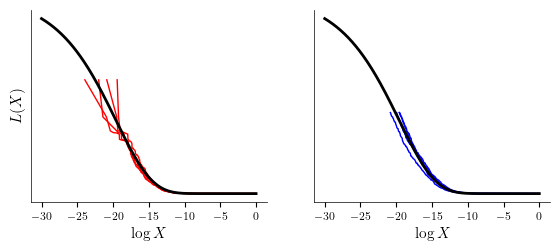

In [197]:
logXarray = np.linspace(-30, 0, 1000)
Xarray = np.exp(logXarray)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6.7,2.5))
for _ in range(4):
    X = generate_Xs(nk)
    logX = np.log(X)
    ax1.plot(logX, L, lw=1, color='red')
    X1 = generate_Xs(nk1)
    logX1 = np.log(X1)
    ax2.plot(logX1, L1, lw=1, color='blue')
    
for ax in fig.axes:
    ax.set_xlabel('$\log X$')
    ax.set_yticks([])
    ax.plot(logXarray, gaussian_L(Xarray, [10, 0.1]), color='black', lw=2, label='True likelihood')

ax1.set_ylabel(f"$L(X)$")
plt.savefig('../../../report/figures/Xlive_variance.pdf', format='pdf', bbox_inches='tight')

#### **Live points outside posterior bulk**

In [5]:
logXarray = np.linspace(-100, 0, 1000)
Xarray = np.exp(logXarray)
theta = [10, 0.001]
logLarray = middle.func(Xarray, theta)
Larray = np.exp(logLarray)

In [6]:
nlive = 100
ndead = 5000
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = np.log(X_mean)
alphas = np.arange(0, 1.1, 0.1)

In [9]:
Xsample = generate_Xs(nk)
logLsample = middle.func(Xsample, theta)
Lsample = np.exp(logLsample)

/home/zixiao/Documents/III/project/aeons/aeons/likelihoods.py:109: RuntimeWarning: invalid value encountered in power
  return (2*sigma**2 * (logLmax - logL))**(d/2)
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


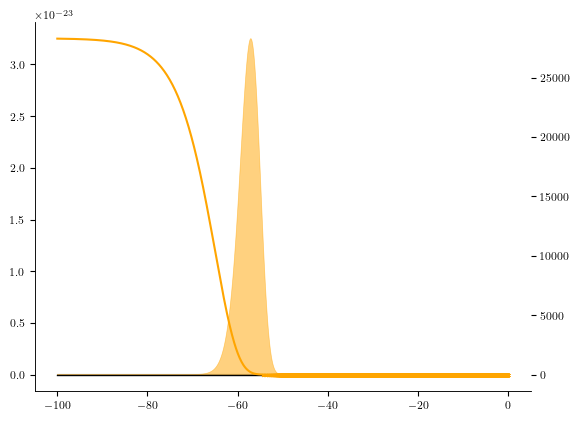

In [10]:
theta_l = minimise_bandwidth(logLsample, X_mean, ndead, alphas)
fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax2.plot(logXarray, Larray, lw=1, color='black')
ax2.plot(logX_mean, Lsample, 'x', color='orange', ms=2)
ax2.plot(logXarray, np.exp(full.func(Xarray, theta_l)), color='orange')
ax1.fill(logXarray, Larray*Xarray, lw=1, color='gray', alpha=0.5);
ax1.fill(logXarray, np.exp(full.func(Xarray, theta_l))*Xarray, color='orange', alpha=0.5)